# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

In [8]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

In [14]:
#!pip install opencv-python

     |████████████████████████████████| 51.6MB 826kB/s eta 0:00:011


### Import modules

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys


# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [91]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=15000 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


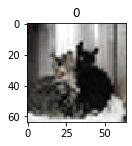

In [92]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

### The cnn_model_fn has to be defined here by the student

In [93]:
def cnn_model_fn(features, labels, mode):
    
    n_fc1=32
    n_outputs = 2
    #Input Layer
    input_layer=tf.reshape(features['x'], [-1,img_size,img_size,num_channels])
    #Conv Layer 1
    convolution1= tf.layers.conv2d(inputs=input_layer, filters=32,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    #Poll Layer 1
    pool1=tf.layers.max_pooling2d(inputs=convolution1, pool_size=[2,2], strides=2)
    # Conv 2
    
    convolution2= tf.layers.conv2d(inputs=pool1, filters=64,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    #pool Layer 2
    
    pool2=tf.layers.max_pooling2d(inputs=convolution2, pool_size=[2,2], strides=2)
    
    #FC layer
    #Flatten the Pool 2 Layer before we connect to FC layer
    
    pool2Output_shape=pool2.get_shape()
    num_fetures_pool2=pool2Output_shape[1:4].num_elements()
    print("Pool2 output no of feature per image :",num_fetures_pool2)
    pool2Flattened=tf.reshape(pool2,[-1,num_fetures_pool2])
    
    denseLayer = tf.layers.dense(inputs=pool2Flattened, units=n_fc1, activation=tf.nn.relu)

    #Dropout Layer
    
    dropout=tf.layers.dropout(inputs=denseLayer, training=mode==tf.estimator.ModeKeys.TRAIN)
    
    #Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=n_outputs)
    
    
    #Evaluation Training
    
    predictions={"classes": tf.argmax(input=logits, axis=1),
                 "probabilities":tf.nn.softmax(logits, name="softmax_tensor")
                }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,predictions=predictions)
    
    
    # if the mode is for Training or Evalution
    
    onehotlabels=tf.one_hot(indices=tf.cast(labels,tf.int32),depth=2)
    loss=tf.losses.softmax_cross_entropy(onehot_labels=onehotlabels, logits=logits)
    #train step
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)


#eval step
    eval_metrics_ops={"accuracy": tf.metrics.accuracy(labels=labels,predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metrics_ops)


### Run the tensorflow model

This section will use the model defined by the student and run the training and evaluation step

In [94]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x642358390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Pool2 output no of feature per image : 4096
INFO:tensorflo

INFO:tensorflow:Restoring parameters from /tmp/pets_convnet_model/model.ckpt-2800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2800 into /tmp/pets_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00759799 0.99240196]
 [0.97259223 0.02740781]
 [0.9999994  0.00000065]
 [0.00000507 0.9999949 ]
 [0.99933237 0.0006676 ]
 [0.00000172 0.99999833]
 [0.00008224 0.99991775]
 [0.99047697 0.00952307]
 [0.00005686 0.99994314]
 [0.00005979 0.99994016]]
INFO:tensorflow:loss = 0.0045860256, step = 2801
INFO:tensorflow:probabilities = [[1.         0.        ]
 [1.         0.00000005]
 [0.00577469 0.9942253 ]
 [0.99999607 0.00000399]
 [0.9993493  0.00065064]
 [0.00000012 0.9999999 ]
 [0.99998546 0.00001449]
 [0.9804521  0.01954792]
 [0.02900591 0.97099406]
 [0.00000382 0.9999962 ]] (0.757 sec)
INFO:tensorflow:global_step/sec: 71.069
INFO:tensorflow:probabilities = [[0.9999976  0.00000235]
 [1.         0.00000002]
 

INFO:tensorflow:probabilities = [[0.99926895 0.00073099]
 [0.99996936 0.00003059]
 [0.9999976  0.00000237]
 [0.9408828  0.05911717]
 [1.         0.00000003]
 [0.00000005 1.        ]
 [0.00012726 0.9998727 ]
 [0.00000064 0.9999994 ]
 [0.99832624 0.00167381]
 [0.0000039  0.99999607]] (0.669 sec)
INFO:tensorflow:global_step/sec: 75.8443
INFO:tensorflow:probabilities = [[0.99999964 0.00000036]
 [0.00000049 0.9999995 ]
 [0.00000083 0.99999917]
 [0.00000489 0.9999951 ]
 [0.00178891 0.99821115]
 [0.9999925  0.00000755]
 [0.         1.        ]
 [0.00000001 1.        ]
 [0.00000197 0.999998  ]
 [0.00005133 0.9999486 ]] (0.649 sec)
INFO:tensorflow:loss = 0.00018579405, step = 4001 (1.319 sec)
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.00001812 0.9999819 ]
 [0.00018214 0.9998179 ]
 [0.9999876  0.00001234]
 [1.         0.00000004]
 [0.00000002 1.        ]
 [0.00805156 0.99194837]
 [0.00121318 0.99878687]
 [0.00001764 0.99998236]
 [0.00153238 0.9984676 ]] (0.671 sec)
INFO:tensorf

INFO:tensorflow:loss = 0.021707306, step = 5101 (1.256 sec)
INFO:tensorflow:probabilities = [[0.99999404 0.00000591]
 [0.9999989  0.00000104]
 [0.9999962  0.00000377]
 [0.03434598 0.9656541 ]
 [0.9999989  0.00000101]
 [0.99927706 0.00072302]
 [0.9999999  0.00000008]
 [1.         0.        ]
 [0.00013375 0.99986625]
 [1.         0.        ]] (0.625 sec)
INFO:tensorflow:global_step/sec: 80.3024
INFO:tensorflow:probabilities = [[0.00002857 0.9999714 ]
 [0.9999999  0.00000011]
 [0.01246672 0.9875332 ]
 [0.9966079  0.00339208]
 [0.         1.        ]
 [0.00001283 0.9999871 ]
 [0.00000209 0.99999785]
 [0.00000548 0.9999945 ]
 [0.00027935 0.99972063]
 [0.00047424 0.9995258 ]] (0.620 sec)
INFO:tensorflow:loss = 0.0016745969, step = 5201 (1.245 sec)
INFO:tensorflow:probabilities = [[0.00000473 0.99999523]
 [0.00000047 0.9999995 ]
 [0.999998   0.00000205]
 [0.9999999  0.0000001 ]
 [0.9998294  0.00017056]
 [0.00000011 0.9999999 ]
 [0.99966836 0.00033164]
 [1.         0.        ]
 [0.00306921 0.9

INFO:tensorflow:loss = 5.1278133e-05, step = 6301 (1.242 sec)
INFO:tensorflow:probabilities = [[1.         0.00000001]
 [0.00344407 0.9965559 ]
 [0.0002033  0.9997967 ]
 [0.         1.        ]
 [0.9997366  0.00026337]
 [0.00001088 0.99998915]
 [0.00000498 0.999995  ]
 [0.9999999  0.00000017]
 [0.99994695 0.00005304]
 [0.         1.        ]] (0.625 sec)
INFO:tensorflow:global_step/sec: 80.5708
INFO:tensorflow:probabilities = [[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.9999989  0.00000111]
 [0.99997056 0.00002945]
 [1.         0.        ]
 [0.9999999  0.00000006]
 [0.99999833 0.0000017 ]
 [0.00000518 0.9999949 ]
 [0.00000401 0.99999595]] (0.616 sec)
INFO:tensorflow:loss = 4.1484373e-06, step = 6401 (1.241 sec)
INFO:tensorflow:probabilities = [[0.00000061 0.9999994 ]
 [1.         0.00000004]
 [0.9999933  0.00000672]
 [0.9999974  0.00000268]
 [0.00000069 0.9999993 ]
 [0.00000148 0.99999857]
 [0.99880445 0.0011955 ]
 [0.00001355 0.9999864 ]
 [0.99931145 

INFO:tensorflow:loss = 0.0007176028, step = 7501 (1.932 sec)
INFO:tensorflow:probabilities = [[0.0000626  0.9999374 ]
 [0.00000004 1.        ]
 [0.         1.        ]
 [0.99957174 0.00042827]
 [0.         1.        ]
 [0.         1.        ]
 [0.00000632 0.9999937 ]
 [0.         1.        ]
 [0.00000068 0.9999993 ]
 [0.00009608 0.9999039 ]] (0.981 sec)
INFO:tensorflow:global_step/sec: 49.3924
INFO:tensorflow:probabilities = [[1.         0.00000001]
 [0.9999988  0.00000114]
 [0.00000001 1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.9999999  0.00000006]
 [1.         0.00000001]
 [1.         0.        ]
 [0.999734   0.00026605]
 [1.         0.        ]] (1.044 sec)
INFO:tensorflow:loss = 2.6735104e-05, step = 7601 (2.026 sec)
INFO:tensorflow:probabilities = [[0.99932384 0.00067612]
 [0.9999802  0.00001976]
 [1.         0.        ]
 [0.00000292 0.99999714]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00001153 0.99998844]
 [0.         1

INFO:tensorflow:loss = 0.0005167146, step = 8701 (5.055 sec)
INFO:tensorflow:probabilities = [[0.00025244 0.9997476 ]
 [0.00000001 1.        ]
 [0.9999975  0.00000248]
 [0.00000194 0.9999981 ]
 [0.00000008 0.9999999 ]
 [0.9999906  0.00000942]
 [1.         0.        ]
 [0.00019931 0.99980074]
 [1.         0.        ]
 [0.00339181 0.99660826]] (2.167 sec)
INFO:tensorflow:global_step/sec: 22.8527
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.99996805 0.0000319 ]
 [1.         0.        ]
 [0.9999939  0.00000611]
 [0.01266013 0.98733985]
 [1.         0.        ]
 [0.         1.        ]
 [0.45527992 0.5447201 ]
 [0.99999917 0.00000088]
 [0.00012576 0.99987423]] (2.208 sec)
INFO:tensorflow:loss = 0.062038876, step = 8801 (4.375 sec)
INFO:tensorflow:probabilities = [[0.9995066  0.00049334]
 [1.         0.        ]
 [0.00000093 0.99999905]
 [1.         0.        ]
 [0.00000002 1.        ]
 [0.00000028 0.99999976]
 [1.         0.        ]
 [0.99945694 0.00054302]
 [0.9999982  0.0

INFO:tensorflow:loss = 1.9787609e-05, step = 9901 (2.030 sec)
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.00000434 0.9999957 ]
 [0.00000008 0.9999999 ]
 [0.00001608 0.9999839 ]
 [0.0000016  0.99999845]
 [0.00000002 1.        ]
 [0.9998987  0.00010133]
 [0.99999964 0.00000036]
 [0.9997969  0.00020315]
 [1.         0.        ]] (1.043 sec)
INFO:tensorflow:global_step/sec: 48.5917
INFO:tensorflow:probabilities = [[0.00000003 1.        ]
 [0.00000045 0.9999995 ]
 [0.99999964 0.00000037]
 [0.0000002  0.99999976]
 [0.         1.        ]
 [1.         0.        ]
 [0.00000002 1.        ]
 [0.         1.        ]
 [0.99658597 0.00341405]
 [0.00000002 1.        ]] (1.015 sec)
INFO:tensorflow:loss = 0.00034209358, step = 10001 (2.058 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.9993268  0.00067319]
 [0.00000934 0.9999907 ]
 [0.         1.        ]
 [0.99998844 0.00001153]
 [0.99999976 0.00000029]
 [0.         1.        ]
 [1.         0.        ]
 [1.        

INFO:tensorflow:loss = 0.012081333, step = 11101 (1.750 sec)
INFO:tensorflow:probabilities = [[0.999995   0.00000501]
 [0.9999541  0.00004587]
 [0.99999607 0.00000394]
 [0.         1.        ]
 [0.0000002  0.99999976]
 [1.         0.        ]
 [1.         0.        ]
 [0.00000001 1.        ]
 [0.00000007 0.9999999 ]
 [0.         1.        ]] (0.880 sec)
INFO:tensorflow:global_step/sec: 56.9821
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.00000402 0.99999595]
 [1.         0.        ]
 [0.9999995  0.00000052]
 [1.         0.00000004]
 [0.         1.        ]
 [0.00001722 0.99998283]
 [1.         0.        ]
 [1.         0.        ]
 [0.00002919 0.9999708 ]] (0.875 sec)
INFO:tensorflow:loss = 5.0901785e-06, step = 11201 (1.755 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.00258114 0.9974189 ]
 [0.         1.        ]
 [0.00000003 1.        ]
 [0.00012942 0.99987054]
 [0.00000001 1.        ]
 [0.00001746 0.9999826 ]
 [0.9999862  0.00001381]
 [0.9999956  

INFO:tensorflow:loss = 3.325918e-06, step = 12301 (2.073 sec)
INFO:tensorflow:probabilities = [[0.99999774 0.00000224]
 [1.         0.00000002]
 [0.0001421  0.9998579 ]
 [1.         0.00000001]
 [1.         0.        ]
 [0.00000017 0.9999999 ]
 [0.9999982  0.00000182]
 [0.00000826 0.9999918 ]
 [0.         1.        ]
 [1.         0.        ]] (1.023 sec)
INFO:tensorflow:global_step/sec: 46.7871
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.0000001  0.9999999 ]
 [0.00364426 0.9963558 ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.9998636  0.00013641]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]] (1.114 sec)
INFO:tensorflow:loss = 0.0003787392, step = 12401 (2.138 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [1.         0.00000002]
 [1.         0.        ]
 [1.         0.00000002]
 [0.00000562 0.9999944 ]
 [1.         0.        ]
 [0.00000003 1.        ]
 [0.9977724  0.00222762]
 [1.         

INFO:tensorflow:loss = 0.0053638937, step = 13501 (3.034 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.00000001]
 [1.         0.        ]
 [0.0000005  0.9999995 ]
 [1.         0.        ]] (1.575 sec)
INFO:tensorflow:global_step/sec: 31.5526
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.9999962  0.00000383]
 [1.         0.        ]
 [0.9999987  0.0000013 ]
 [1.         0.00000001]
 [0.         1.        ]
 [1.         0.00000001]
 [0.0075433  0.9924567 ]
 [0.         1.        ]
 [1.         0.        ]] (1.594 sec)
INFO:tensorflow:loss = 0.0007577052, step = 13601 (3.169 sec)
INFO:tensorflow:probabilities = [[0.00000778 0.99999225]
 [1.         0.        ]
 [0.00000298 0.999997  ]
 [1.         0.        ]
 [0.00000001 1.        ]
 [0.00000256 0.9999975 ]
 [0.         1.        ]
 [0.         1.        ]
 [0.00000075 

INFO:tensorflow:loss = 7.828485e-05, step = 14701 (3.679 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.00000541 0.99999464]
 [0.9984497  0.00155026]
 [0.00198846 0.99801147]
 [0.         1.        ]] (1.729 sec)
INFO:tensorflow:global_step/sec: 28.0742
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.99999976 0.00000021]
 [0.         1.        ]
 [0.11955117 0.8804488 ]
 [0.00000017 0.9999999 ]
 [0.00000002 1.        ]
 [0.9999995  0.00000049]
 [0.         1.        ]
 [0.         1.        ]
 [0.00000001 1.        ]] (1.833 sec)
INFO:tensorflow:loss = 0.012732434, step = 14801 (3.562 sec)
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.0000001  0.9999999 ]
 [0.99999964 0.0000003 ]
 [0.00000001 1.        ]
 [0.         1.        ]
 [0.9999999  0.00000013]
 [1.         0.        ]
 [0.00009522 0.99990475]
 [1.         0

INFO:tensorflow:loss = 0.0024104759, step = 15901 (2.364 sec)
INFO:tensorflow:probabilities = [[0.45412672 0.5458733 ]
 [0.         1.        ]
 [1.         0.00000001]
 [1.         0.        ]
 [0.9999999  0.0000001 ]
 [0.99979836 0.00020165]
 [1.         0.        ]
 [0.00000002 1.        ]
 [0.         1.        ]
 [0.00001466 0.99998534]] (1.125 sec)
INFO:tensorflow:global_step/sec: 43.9619
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.9999999  0.00000007]
 [1.         0.        ]
 [0.00000039 0.99999964]
 [0.00000005 1.        ]
 [0.         1.        ]
 [0.9999429  0.00005706]
 [0.9999958  0.00000412]
 [0.9999999  0.00000007]
 [1.         0.        ]] (1.150 sec)
INFO:tensorflow:loss = 6.1867986e-06, step = 16001 (2.275 sec)
INFO:tensorflow:probabilities = [[0.99999    0.00001004]
 [0.99999785 0.00000218]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.00000792 0.99999213]
 [0.9999999  0.00000011]
 [0.00000001 1.        ]
 [0.00000015

INFO:tensorflow:loss = 7.0748196e-05, step = 17101 (2.876 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.00035738 0.9996426 ]
 [0.00044392 0.999556  ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00000173 0.9999982 ]
 [0.00000004 1.        ]
 [0.00000003 1.        ]
 [0.00000185 0.9999981 ]
 [0.         1.        ]] (1.477 sec)
INFO:tensorflow:global_step/sec: 33.9639
INFO:tensorflow:probabilities = [[0.         1.        ]
 [1.         0.00000002]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.00003026 0.9999697 ]
 [0.9986998  0.0013002 ]
 [1.         0.        ]
 [0.         1.        ]] (1.467 sec)
INFO:tensorflow:loss = 0.00013313166, step = 17201 (2.944 sec)
INFO:tensorflow:probabilities = [[0.99999964 0.00000033]
 [0.         1.        ]
 [0.00000037 0.99999964]
 [1.         0.        ]
 [0.         1.        ]
 [0.00000571 0.9999943 ]
 [1.         0.        ]
 [0.00000001 1.        ]
 [1.       

Pool2 output no of feature per image : 4096
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-12T23:25:46Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/pets_convnet_model/model.ckpt-17800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-12-23:25:47
INFO:tensorflow:Saving dict for global step 17800: accuracy = 0.55, global_step = 17800, loss = 5.625337
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 17800: /tmp/pets_convnet_model/model.ckpt-17800
{'accuracy': 0.55, 'loss': 5.625337, 'global_step': 17800}
